**21. CNN using PyTorch**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# set random seeds for reproducibility
random_seed = 14

In [2]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
df = pd.read_csv('datasets/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [ ]:
# getting data as numpy arrays
X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy()

class_labels =  ["T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"]

# perform train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


# creating dataset class
class FMNIST_DATASET(Dataset):
    def __init__(self,X,y):
        self.X = tr.tensor(X, dtype = tr.float32).reshape(-1,1,28,28) # placeholder, channels, height, width
        self.y = tr.tensor(y, dtype = tr.long)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.normalize(self.X[index]),self.y[index]

    def normalize(self,X):
        return (X/255.0)
    
train_dataset = FMNIST_DATASET(X_train,y_train)
test_dataset = FMNIST_DATASET(X_test,y_test)


BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle = False)

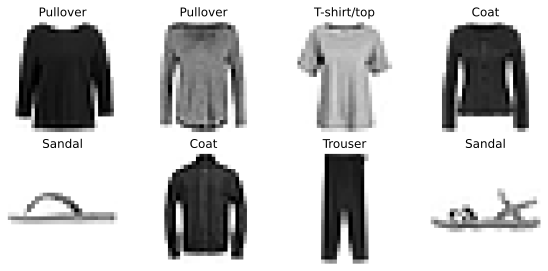

In [42]:
fig,axes = plt.subplots(2,4,figsize = (8,4))

images,labels = next(iter(train_loader))


for i,ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(),cmap = 'binary')
    ax.axis('off')
    ax.set_title(f'{class_labels[labels[i]]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

**Notes:**
* CNNs work the best on grid/matrix based data.
* Understands the spatial patterns in grid/matrix based data very well.
* In PyTorch the input image is `(batch,channels,height,width)` while TensorFlow the input image is `(batch,height,width,channels)`

In [50]:
class FMNIST_NET(nn.Module):
    def __init__(self):
        super().__init__()

        # feature extractor 
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= (3,3), padding = 'same'),
            nn.BatchNorm2d(num_features= 32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= (3,3), padding = 'same'),
            nn.BatchNorm2d(num_features= 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*7*7 , out_features = 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(in_features = 64, out_features = 10)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

from torchinfo import summary
demo_model = FMNIST_NET()
summary(demo_model)

Layer (type:depth-idx)                   Param #
FMNIST_NET                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       18,496
│    └─BatchNorm2d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-2                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      401,536
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,256
│    └─ReLU: 2-14                        --
│    └─Dropout: 2-15                     --
│    └─Linear: 2-16                      650
Total params: 429,450
Trainable params: 429,450
Non-trainable params: 0

In [55]:
# learning rate and epochs
lr = 1e-3
epochs = 100

# instantiating the model
fnet = FMNIST_NET()

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = tr.optim.Adam(fnet.parameters(), lr = lr, weight_decay=1e-4)

In [56]:
fnet = fnet.to(device) # move the model to GPU

In [57]:
# training loop
for epochi in range(epochs):
    fnet.train()
    batch_loss = []
    for X_batch,y_batch in train_loader:
        # moving data to device (GPU)
        X_batch,y_batch = X_batch.to(device),y_batch.to(device)
        
        # forward pass
        y_pred = fnet(X_batch)

        # loss calculation
        loss = loss_fn(y_pred,y_batch)
        batch_loss.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # upgrade parameters
        optimizer.step()

    mean_batch_loss = np.mean(batch_loss)
    
    # perform validation
    fnet.eval()
    val_correct = 0
    val_total = 0

    with tr.no_grad(): # disable gradient tracking
        for X_val,y_val in test_loader:
            # moving data to device(GPU)
            X_val,y_val = X_val.to(device),y_val.to(device)
            
            y_pred = fnet(X_val)
            preds = tr.argmax(y_pred,dim=1)
            val_correct += (preds == y_val).sum().item()
            val_total += y_val.size(0)
    val_acc = (val_correct / val_total)*100

    print(f'Epoch: {epochi+1}, Loss: {mean_batch_loss}, Val Accuracy:{val_acc:.2f}%')

Epoch: 1, Loss: 1.1207178155581157, Val Accuracy:76.75%
Epoch: 2, Loss: 0.6784672019879023, Val Accuracy:79.83%
Epoch: 3, Loss: 0.5873778579632442, Val Accuracy:84.42%
Epoch: 4, Loss: 0.5219812684257825, Val Accuracy:83.50%
Epoch: 5, Loss: 0.48475379794836043, Val Accuracy:85.83%
Epoch: 6, Loss: 0.42987116013964016, Val Accuracy:86.08%
Epoch: 7, Loss: 0.3997987510760625, Val Accuracy:85.92%
Epoch: 8, Loss: 0.3811673475801945, Val Accuracy:88.42%
Epoch: 9, Loss: 0.3397490798185269, Val Accuracy:87.00%
Epoch: 10, Loss: 0.32220812161763507, Val Accuracy:87.75%
Epoch: 11, Loss: 0.30790639837582906, Val Accuracy:86.33%
Epoch: 12, Loss: 0.2927393856892983, Val Accuracy:87.33%
Epoch: 13, Loss: 0.26565370860199133, Val Accuracy:84.33%
Epoch: 14, Loss: 0.2664782610038916, Val Accuracy:86.75%
Epoch: 15, Loss: 0.2530400496721268, Val Accuracy:87.83%
Epoch: 16, Loss: 0.2248426730930805, Val Accuracy:88.42%
Epoch: 17, Loss: 0.23039635290702185, Val Accuracy:88.92%
Epoch: 18, Loss: 0.199949367580314

In [60]:
def evaluate_model(model,test_loader):
    correct_preds = 0
    total_preds = 0

    device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')

    model.to(device)

    with tr.no_grad():
        for X_batch,y_batch in test_loader:
            # moving data to device(GPU)
            X_batch,y_batch = X_batch.to(device),y_batch.to(device)

            y_pred = model(X_batch)
            preds = tr.argmax(y_pred, dim = 1)
            correct_preds+=(preds == y_batch).sum().item()
            total_preds += y_batch.size(0)
        accuracy = (correct_preds/total_preds)
        return accuracy
    
evaluate_model(fnet,test_loader) 

0.8791666666666667